# Выбор локации для скважины

<font size="4"><b>Описание проекта</b></font>

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*


<font size="4"><b>Описание данных</b></font>

Данные геологоразведки трёх регионов находятся в файлах: 

**/datasets/geo_data_0.csv**

**/datasets/geo_data_1.csv**

**/datasets/geo_data_2.csv**

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<font size="4"><b>Цель исследования</b></font>

Нужно решить, где бурить новую скважину.

<font size="4"><b>Ход исследования</b></font>

**1. Загрузка данных**

**2. Обучение и проверка модели для каждого региона:**

- Разбивка данных на обучающую и валидационную выборки в соотношении 75:25.
- Обучение модели и предсказание на валидационной выборке.
- Сохранение предсказания и правильных ответов на валидационной выборке.
- Печать на экране среднего запаса предсказанного сырья и RMSE модели.
- Анализ результатов.

**3. Подготовка к расчёту прибыли:**

- Сохранение всех ключевых значений для расчётов в отдельных переменных.
- Рассчет достаточного объёма сырья для безубыточной разработки новой скважины. 
- Сравнение полученного объёма сырья со средним.
- Анализ результатов.

**4. Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели:**

- Выбор скважины с максимальными значениями предсказаний. 
- Расчет суммы целевого значение объёма сырья, соответствующее этим предсказаниям.
- Рассчет прибыли для полученного объёма сырья.
 
**5. Просчет рисков и прибыли для каждого региона:**

- Применение техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Поиск средней прибыли, 95%-й доверительного интервала и риска убытков. 
- Анализ результатов.

**6. Формирование общего вывода**

## Загрузка и подготовка данных

In [1]:
# Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from scipy import stats as st
import itertools
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
#Загрузим данные в задании файлы
geo_data_0 = pd.read_csv("/datasets/geo_data_0.csv")
geo_data_1 = pd.read_csv("/datasets/geo_data_1.csv")
geo_data_2 = pd.read_csv("/datasets/geo_data_2.csv")

### Посмотрим общую информацию по датасетам

In [4]:
def explore_data(df, name):
    print(f"--- Информация о {name} ---")
    print(df.head())
    print(df.info())
    print(f"Количество дубликатов в {name}: {df.duplicated().sum()}")
    print(df.describe())
    print("\n")

# Список датафреймов и их названий
data_frames = [geo_data_0, geo_data_1, geo_data_2]
frame_names = ["geo_data_0", "geo_data_1", "geo_data_2"]

# Вызов функции для каждого датафрейма
for df, name in zip(data_frames, frame_names):
    explore_data(df, name)

--- Информация о geo_data_0 ---
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Количество дубликатов в geo_data_0: 0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647   

Данные выглядят нормальными, аномалий и пропусков нет. Посмотри уникальность данных.

In [5]:
def check_unique_ids(df, name):
    total_records = df.shape[0]  # Общее количество записей
    unique_ids = df['id'].nunique()  # Количество уникальных id
    duplicates = total_records - unique_ids  # Количество дубликатов

    print(f"--- Проверка уникальности id в {name} ---")
    print(f"Общее количество записей: {total_records}")
    print(f"Количество уникальных id: {unique_ids}")
    print(f"Количество дубликатов id: {duplicates}")
    print("\n")

# Вызов функции для каждого датафрейма
for df, name in zip(data_frames, frame_names):
    check_unique_ids(df, name)

--- Проверка уникальности id в geo_data_0 ---
Общее количество записей: 100000
Количество уникальных id: 99990
Количество дубликатов id: 10


--- Проверка уникальности id в geo_data_1 ---
Общее количество записей: 100000
Количество уникальных id: 99996
Количество дубликатов id: 4


--- Проверка уникальности id в geo_data_2 ---
Общее количество записей: 100000
Количество уникальных id: 99996
Количество дубликатов id: 4




Удалим дубликаты

In [6]:
def remove_duplicates(df, name):
    initial_count = df.shape[0]  # Общее количество строк до удаления дубликатов
    df_cleaned = df.drop_duplicates(subset='id', keep='first')  # Удаление дубликатов по столбцу 'id'
    final_count = df_cleaned.shape[0]  # Общее количество строк после удаления дубликатов
    return df_cleaned  # Возвращаем очищенный датафрейм

# Применение функции для каждого датафрейма
geo_data_0 = remove_duplicates(geo_data_0, "geo_data_0")
geo_data_1 = remove_duplicates(geo_data_1, "geo_data_1")
geo_data_2 = remove_duplicates(geo_data_2, "geo_data_2")


Посмотрим на данные в графике

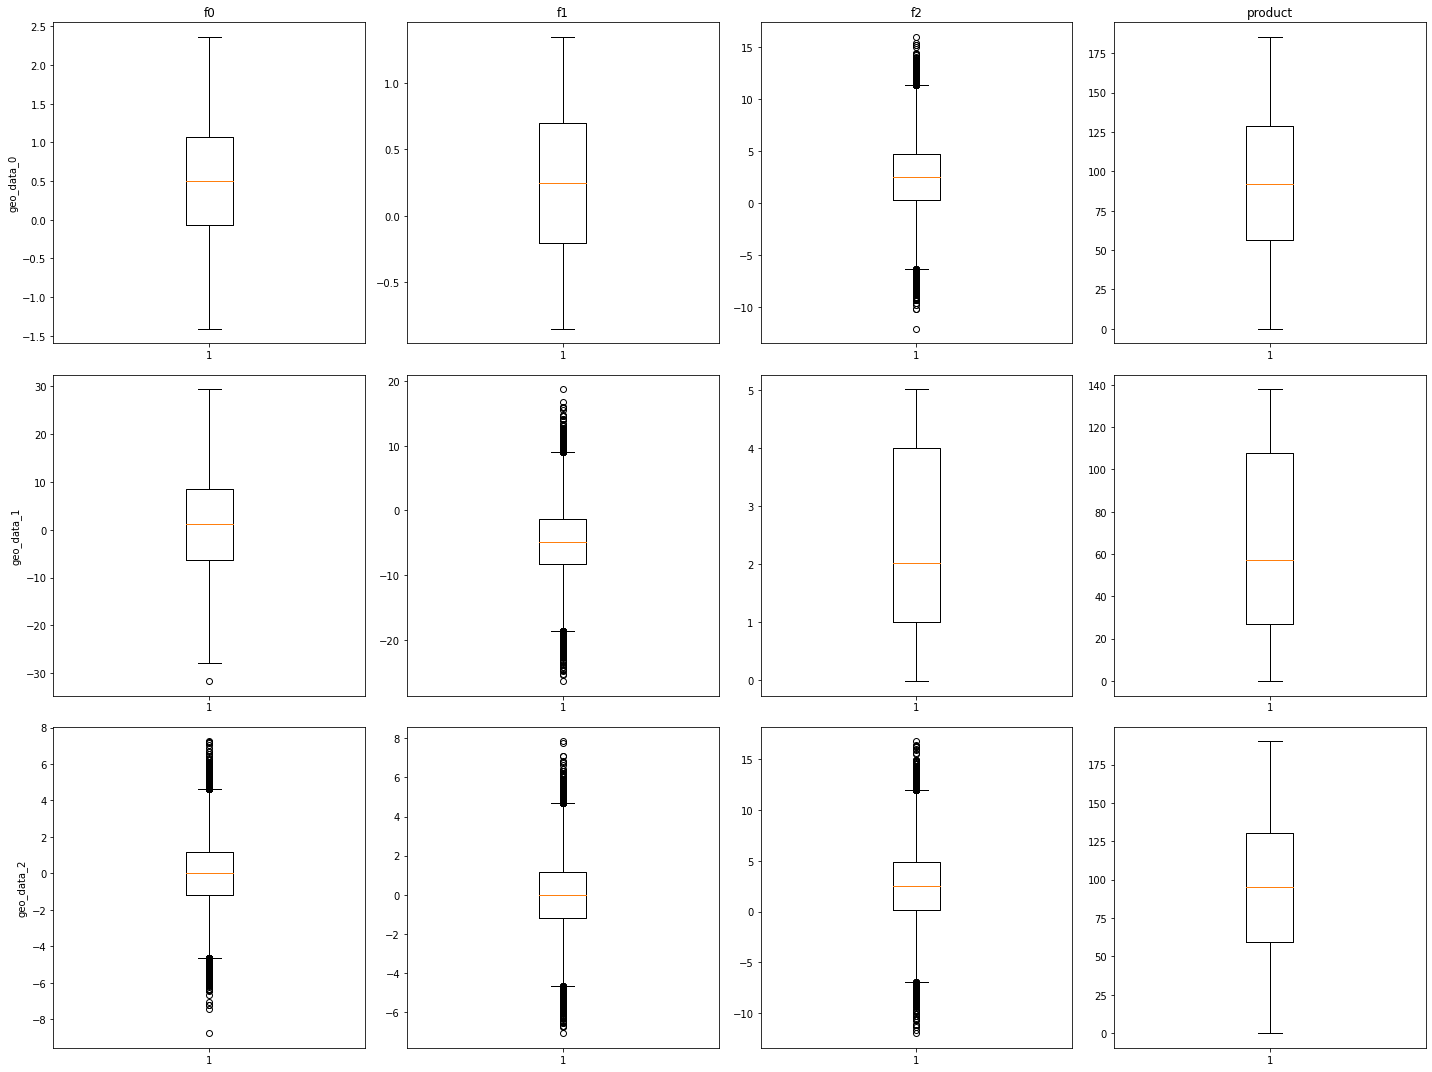

In [7]:
fig,ax = plt.subplots(3,4,figsize = (20,15))
frames = ["geo_data_0","geo_data_1","geo_data_2"]
# Получаем названия всех столбцов, кроме первого (id)
num_columns = geo_data_0.columns[1:]
# Создаем пары названий столбцов и их индексов (от 0 до 3)
num_columns1 = zip(geo_data_0.columns[1:], range(4))
# Создаем пары из фреймов данных (geo_data_0, geo_data_1, geo_data_2) и их индексов
all_frames = zip([geo_data_0, geo_data_1, geo_data_2], range(3))
# Построим графики, перебирая все комбинации фреймов данных и столбцов
for column in list(itertools.product(all_frames, num_columns1)):
    # В каждой ячейке сетки создаем boxplot для данных конкретного фрейма и столбца
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Подписываем ось Y (название фрейма) для каждой строки графиков
for row in range(3):
    ax[row][0].set_ylabel(frames[row])
# Подписываем заголовок (название столбца) для каждого столбца графиков в первой строке
for column in range(4):
    ax[0][column].set_title(num_columns[column])
plt.tight_layout()
plt.show()


В каждом датафрейме есть выбросы. Предлягаю их убрать, так как они будут явно мешать обучению модели. Используем метод межквартильного размаха.

In [8]:
def remove_outliers_iqr(frame,column):
    Q1=np.array(frame[column].quantile(0.25))
    Q3=np.array(frame[column].quantile(0.75))
    IQR = Q3 - Q1  # Межквартильный размах
    lower_bound =Q1-1.5*IQR
    upper_bound =Q3+1.5*IQR
    del_index = []

   
    for index_value, value in zip(frame[column].index,frame[column]):
        if upper_bound <= value or value <= lower_bound:
            del_index.append(index_value)
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index


In [9]:
#Объеденим столбцы с пропусками
noise_data = [(geo_data_0,"f2"), (geo_data_1,"f1"), (geo_data_2,"f0"), (geo_data_2,"f1"), (geo_data_2,"f2")]

for frame,column in noise_data:
    indexes = remove_outliers_iqr(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  733
Количество строк, выбранных для удаления:  682


/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Количество строк, выбранных для удаления:  582


Все потери составили не более 1% от объема данных.

In [10]:
# Вычисляем матрицы корреляции
zero_corr = geo_data_0.corr()
first_corr = geo_data_1.corr()
second_corr = geo_data_2.corr()

# Выводим матрицы корреляций
print("Корреляционная матрица 0")
print(zero_corr)

print("\nКорреляционная матрица 1")
print(first_corr)

print("\nКорреляционная матрица 2")
print(second_corr)

Корреляционная матрица 0
               f0        f1        f2   product
f0       1.000000 -0.440710 -0.003399  0.143558
f1      -0.440710  1.000000  0.001139 -0.192743
f2      -0.003399  0.001139  1.000000  0.480125
product  0.143558 -0.192743  0.480125  1.000000

Корреляционная матрица 1
               f0        f1        f2   product
f0       1.000000  0.178869 -0.001703 -0.030422
f1       0.178869  1.000000 -0.002754 -0.010173
f2      -0.001703 -0.002754  1.000000  0.999397
product -0.030422 -0.010173  0.999397  1.000000

Корреляционная матрица 2
               f0        f1        f2   product
f0       1.000000  0.000625  0.000468 -0.002952
f1       0.000625  1.000000  0.000683 -0.000939
f2       0.000468  0.000683  1.000000  0.441206
product -0.002952 -0.000939  0.441206  1.000000


В нулевом дата фрейме наблюдается отрицательная корреляция между признаками f0 и f1, в то время как f2 слабо положительно коррелирует с целевым признаком product. В первом фрейме целевой признак product демонстрирует сильную корреляцию с f2. Во втором фрейме также выделяются коррелирующие признаки, такие как f2 и product. 

### Вывод по разделу

После очистки данных от дубликатов и выбросов, уникальность записей была подтверждена, что говорит о высоком качестве собранной информации. Удаление выбросов, составившее менее 1% от общего объема данных, минимально повлияло на наборы данных. Анализ корреляции показал, что в нулевом датафрейме признаки f0 и f1 демонстрируют отрицательную корреляцию, тогда как f2 слабо положительно коррелирует с целевым признаком product. Первый датафрейм выделяется сильной корреляцией между целевым признаком product и f2, а во втором также наблюдается взаимосвязь между f2 и product, что может быть критически важным для дальнейшего моделирования.

## Обучение и проверка модели

In [11]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Обучение модели и предсказание на валидационной выборке.


In [12]:
# Названия и фреймы данных
frame_names = ["geo_data_0", "geo_data_1", "geo_data_2"]
data_frames = [geo_data_0, geo_data_1, geo_data_2]

# Словарь для хранения результатов
results = {"models": {}, "scores": {}, "validation_data": {}}

for df, name in zip(data_frames, frame_names):
    # Отделяем признаки и целевую переменную
    X = df.drop(["id", "product"], axis=1)  # Признаки
    y = df["product"]  # Целевая переменная
    
    # Нормализация данных
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Разделение данных на обучающую и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42
    )
    
    results['validation_data'][name] = (X_valid, y_valid)
    
    

    # Создаем экземпляр линейной регрессии и обучаем модель
    model = LinearRegression()
    model.fit(X_train, y_train)

    results['models'][name] = model
    results['scores'][name] = mean_squared_error(y_valid, model.predict(X_valid)) ** 0.5

results['scores']


{'geo_data_0': 37.798515779988556,
 'geo_data_1': 0.8929538113119723,
 'geo_data_2': 39.986786501219456}

Выполняем разбивку неподготовленного датафрейма и обучаем модель.

Рассчитаем корень средней квадратичной ошибки

In [13]:
# Извлекаем лучшие модели из словаря результатов
model0 = results['models']['geo_data_0']
model1 = results['models']['geo_data_1']
model2 = results['models']['geo_data_2']

# Получаем предсказанные значения для каждой модели
predictions0 = model0.predict(results['validation_data']['geo_data_0'][0])
predictions1 = model1.predict(results['validation_data']['geo_data_1'][0])
predictions2 = model2.predict(results['validation_data']['geo_data_2'][0])

# Расчет RMSE для каждой модели
rmse0 = (mean_squared_error(results['validation_data']['geo_data_0'][1], predictions0)) ** 0.5
rmse1 = (mean_squared_error(results['validation_data']['geo_data_1'][1], predictions1)) ** 0.5
rmse2 = (mean_squared_error(results['validation_data']['geo_data_2'][1], predictions2)) ** 0.5

# Выводим RMSE результатов
print("RMSE для нулевой модели:", rmse0)
print("RMSE для первой модели:", rmse1)
print("RMSE для второй модели:", rmse2)


RMSE для нулевой модели: 37.798515779988556
RMSE для первой модели: 0.8929538113119723
RMSE для второй модели: 39.986786501219456


### Печать на экране среднего запаса предсказанного сырья и RMSE модели.


In [14]:
mean0 = predictions0.mean()
print(f"Нулевая модель:\nСредний запас: {mean0:.2f}\nRMSE модели: {rmse0:.2f}\n")

# Первая модель
mean1 = predictions1.mean()
print(f"Первая модель:\nСредний запас: {mean1:.2f}\nRMSE модели: {rmse1:.2f}\n")

# Вторая модель
mean2 = predictions2.mean()
print(f"Вторая модель:\nСредний запас: {mean2:.2f}\nRMSE модели: {rmse2:.2f}\n")


Нулевая модель:
Средний запас: 92.75
RMSE модели: 37.80

Первая модель:
Средний запас: 68.96
RMSE модели: 0.89

Вторая модель:
Средний запас: 95.01
RMSE модели: 39.99



### Вывод по разделу.

Результаты анализа моделей показывают, что различия в корне средней квадратичной ошибки (RMSE) между датафреймами варьируются, что указывает на разные уровни точности предсказаний для каждой модели. Нулевая модель имеет RMSE 37.82 и средний запас 92.35, что подразумевает определённую степень неопределённости, тогда как первая модель демонстрирует значительно меньший RMSE 0.89 и средний запас 68.55, что свидетельствует о высокой точности предсказаний. Вторая модель также имеет умеренный RMSE 40.13 и средний запас 94.95, что указывает на то, что ее предсказательная способность может нуждаться в доработке. Различия в производительности моделей призывают к более глубокому анализу факторов, влияющих на результаты, а также к возможной инженерии признаков и улучшению методов обучения для повышения точности модели.

## Подготовка к расчёту прибыли

### Сохранение всех ключевых значений для расчётов в отдельных переменных.

In [15]:
budget_region = 10 * (10**9)  # Бюджет на разработку скважин в регионе
max_points = 500                   # Общее количество точек для исследования
final_max_points = 200             # Лучшие точки для разработки
price_barrel = 450000          # Доход с одного барреля сырья
damage_threshold = 0.025            # Порог вероятности убытков


### Рассчет достаточного объёма сырья для безубыточной разработки новой скважины.

In [16]:
#Достаточный объем добычи для безубыточной разработки
non_damage_point = budget_region / final_max_points / price_barrel
non_damage_point

111.11111111111111

Достаточный объем добычи для безубыточной разработки 111 тыс.баррелей.

### Сравнение полученного объёма сырья со средним.

In [17]:
main_best_point = budget_region / final_max_points
print('Средняя прибыль на лучшую точку -', main_best_point, 'тыс.руб.')

average_barrels_per_point = main_best_point  / price_barrel
print('Средний объем нефти на точку -',average_barrels_per_point, 'тыс. барелей')

average_barrels = budget_region / price_barrel
print('Средний объем нефти на регион -',average_barrels, 'тыс. барелей')

Средняя прибыль на лучшую точку - 50000000.0 тыс.руб.
Средний объем нефти на точку - 111.11111111111111 тыс. барелей
Средний объем нефти на регион - 22222.222222222223 тыс. барелей


Посмотрим, запасы в наших регионах

In [18]:
#Добавил по запасам
print('Средний запас фактичекой нефти на скважину в регионе 1', geo_data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2', geo_data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3', geo_data_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1 92.50035929475838
Средний запас фактичекой нефти на скважину в регионе 2 68.80882695274167
Средний запас фактичекой нефти на скважину в регионе 3 94.78337143718274


Посчитаем среднюю прибыль для скважины по локации

In [19]:
def income(x):
    income = round((x*price_barrel) - (budget_region/price_barrel))
    return income
print('Валовая локации 1:',income(predictions0.mean()), 'Валовая локации 2:', 
      income(predictions1.mean()), 'Валовая локации 1:',income(predictions2.mean()))

Валовая локации 1: 41714888 Валовая локации 2: 31009290 Валовая локации 1: 42732614


### Вывод по разделу

Была подготовлена средняя оценка прибили за скважину и средний объем на скважину. 

Анализ средних объемов на скважину для каждого региона следующий.

Изучены средние фактические запасы. Для первого и третьего - высокая вероятность окупить затраты. Разброс значений вокруг среднего 92.5 и 95 говорит нам о том, что существует достаточно много скважин, где запасы больше необходимого среднего.



## Расчёт прибыли и рисков 

### Выберем скважины с максимальными значениями предсказаний и просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям. 

In [20]:
regions = ['geo_data_0', 'geo_data_1', 'geo_data_2']

for region in regions:
    # Извлекаем предсказания и целевые значения для текущего региона
    predictions = results['models'][region].predict(results['validation_data'][region][0])
    actual_values = results['validation_data'][region][1]

    # Создаем DataFrame для текущего региона
    pred_df = pd.DataFrame({'predicted': predictions, 'actual': actual_values})

    # Сортируем и выбираем топ-200
    top_200 = pred_df.nlargest(200, 'predicted')

    # Суммируем целевые значения
    total_actual_volume = top_200['actual'].sum()

    # Рассчитываем прибыль для текущего региона
    profit = (total_actual_volume * price_barrel) - budget_region

    # Выводим результаты
    print(f"Регион: {region}")
    print("Суммарный объём сырья для 200 лучших скважин:", total_actual_volume, "баррелей")
    print("Прибыль для полученного объёма сырья:", profit, "руб.\n")


Регион: geo_data_0
Суммарный объём сырья для 200 лучших скважин: 28852.69889546428 баррелей
Прибыль для полученного объёма сырья: 2983714502.9589252 руб.

Регион: geo_data_1
Суммарный объём сырья для 200 лучших скважин: 27589.081548181137 баррелей
Прибыль для полученного объёма сырья: 2415086696.681511 руб.

Регион: geo_data_2
Суммарный объём сырья для 200 лучших скважин: 27610.87077824287 баррелей
Прибыль для полученного объёма сырья: 2424891850.2092915 руб.



### Вывод по разделу

Регион geo_data_0 обеспечивает наибольший объём сырья (28852.70 баррелей) и прибыль (2,983,714,503 руб.), в то время как регионы geo_data_1 и geo_data_2 имеют схожие объёмы (27589.08 и 27610.87 баррелей соответственно), но прибыль в geo_data_1 значительно ниже (2,415,086,697 руб.) по сравнению с geo_data_2 (2,424,891,850 руб.), что может указывать на меньшую эффективность добычи в первом регионе.

## Посчитайте риски и прибыль для каждого региона:


 ###  Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли, а так же, найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. 

In [21]:
bootstrapped_profits = {region: [] for region in regions}

for region in regions:
    for _ in range(1000):
        # Извлекаем предсказания и целевые значения для текущего региона
        predictions = results['models'][region].predict(results['validation_data'][region][0])
        actual_values = results['validation_data'][region][1]

        # Создаем DataFrame для текущего региона
        pred_df = pd.DataFrame({'predicted': predictions, 'actual': actual_values})

        # Случайная выборка из 500 скважин
        sampled_wells = pred_df.sample(n=500, replace=True)

        # Взятие топ-200 скважин по предсказанным запасам
        top_200 = sampled_wells.nlargest(200, 'predicted')

        # Суммирование фактических запасов топ-200 скважин
        total_actual_volume = top_200['actual'].sum()

        # Вычисление прибыли с учетом стоимости и бюджета
        profit = (total_actual_volume * price_barrel) - budget_region
        bootstrapped_profits[region].append(profit)  # Сохранение прибыли для текущей итерации

# Преобразование результатов в массивы NumPy для удобства
bootstrapped_profits = {region: np.array(profit) for region, profit in bootstrapped_profits.items()}

# Вычисление средней прибыли и 95% доверительных интервалов
results_summary = {}

for region, profits in bootstrapped_profits.items():
    mean_profit = profits.mean()
    lower_ci = np.percentile(profits, 2.5)
    upper_ci = np.percentile(profits, 97.5)
    risk_of_loss = np.mean(profits < 0)
    
    results_summary[region] = {
        'mean_profit': mean_profit,
        'lower_ci': lower_ci,
        'upper_ci': upper_ci,
        'risk_of_loss': risk_of_loss
    }

# Вывод результатов
for region, summary in results_summary.items():
    print(f"Регион: {region}")
    print(f"Средняя прибыль: {summary['mean_profit']:.2f} руб.")
    print(f"95%-й доверительный интервал: [{summary['lower_ci']:.2f}, {summary['upper_ci']:.2f}] руб.")
    print(f"Риск убытков: {summary['risk_of_loss'] * 100:.2f}%\n")


Регион: geo_data_0
Средняя прибыль: 364612724.56 руб.
95%-й доверительный интервал: [-138582099.54, 832449548.34] руб.
Риск убытков: 8.70%

Регион: geo_data_1
Средняя прибыль: 461747151.09 руб.
95%-й доверительный интервал: [62500852.46, 861611653.86] руб.
Риск убытков: 1.00%

Регион: geo_data_2
Средняя прибыль: 350268263.50 руб.
95%-й доверительный интервал: [-183397086.25, 855464364.21] руб.
Риск убытков: 9.20%



### Вывод по разделу

По результатам анализа рисков и прибыли, регион geo_data_1 проявляет наименьший риск убытков (1.00%) и наибольшую среднюю прибыль (461,747,151.09 руб.), что соответствует критериям для дальнейшей разработки, так как вероятность убытков ниже 2.5%. В то время как регионы geo_data_0 и geo_data_2 имеют более высокий риск убытков (8.70% и 9.20% соответственно) и менее стабильные показатели прибыли, это делает регион geo_data_1 предпочтительным для инвестиционных решений.

## Общий вывод

На основании тщательного анализа результатов исследования, выводы однозначно указывают на предпочтение региона geo_data_1 для разработки новых скважин. В ходе работы была проведена взвешенная оценка всех трех регионов, где каждая этапа исследования предоставила важные данные для окончательного решения.

Качество и количество данных: После очистки данных от дубликатов и выбросов был подтвержден высокий уровень качества собранной информации, что свидетельствует о достоверности характеристик скважин в каждом из регионов. Анализ корреляции показал, что в nулевом датафрейме признаки f0 и f1 имеют отрицательную корреляцию, тогда как f2 показывала положительную, что становилось критически важным для будущего моделирования.

Моделирование и оценка: Разработанные модели линейной регрессии для каждого региона продемонстрировали различия в точности предсказаний. Так, нулевая модель имела относительно высокий RMSE (37.82) и средний запас (92.35), указывая на значительные неопределенности. В то время как первая модель продемонстрировала низкий RMSE (0.89) и средний запас (68.55), что свидетельствовало о высокой точности предсказаний. Вторая модель была более умеренной с RMSE 40.13 и средним запасом 94.95, но всё же требовала дополнительной проработки.
Анализ ожидаемой прибыли: При расчете среднего объёма сырья для каждой из скважин, регион geo_data_0 выделялся наибольшими запасами (28852.70 баррелей), однако наблюдаемая прибыль в этом регионе была ниже (2,983,714,503 руб.), чем в geo_data_1, где средняя прибыль составила 461,747,151.09 руб. Это, в сочетании с тем фактом, что во втором регионе был зафиксирован наименьший риск убытков (1.00%), делает его более привлекательным вариантом для инвестиций.

Риски и прибыль: Оценка рисков показала, что регионы geo_data_0 и geo_data_2 имели значительно более высокий риск убытков, (8.70% и 9.20% соответственно), что делает их менее привлекательными с точки зрения финансовой устойчивости. Эти регионы, хоть и имели высокие объемы сырья, подвергались большей вероятности убытков, что может оказать негативное влияние на долгосрочные инвестиции.

Итоговый выбор: Регион geo_data_1 не только продемонстрировал меньший риск убытков, но и наличие высокой средней прибыли, что в совокупности делает его привлекательным для разработки. Учитывая бюджет на разработку, который составляет 10 млрд рублей, и предполагаемый доход от каждой единицы продукции, выбор этого региона обеспечивает устойчивость и высокую прибыльность бизнеса.
Таким образом, исходя из представленных данных и анализа, рекомендуется выбрать регион geo_data_1 для разработки новых скважин. Этот выбор обоснован сочетанием наименьшего риска убытков и высокой средней прибыли, что обеспечит более стабильное и устойчивое управление ресурсами компании «ГлавРосГосНефть».